<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/volcano_earthquake_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌋 Volcano-Earthquake Clustering Analysis

This notebook analyzes the grouping of volcanoes and earthquakes based on proximity 🌍, using a KD-tree for efficient neighbor search.  
Instead of matching only pairs, we form **groups** (clusters) where the distance between any two points is below `dist_max`.  

We plot:
- Number of groups
- Average group size
- Variance of group sizes

For the program to work, you need two CSV files generated using SPARQL queries: https://w.wiki/AXz7 and https://w.wiki/AY2R

> "The Earth is the cradle of humanity, but mankind cannot stay in the cradle forever."  
> — Konstantin Tsiolkovsky 🚀

In [17]:
# Input parameters
f_volcano = "volcanoes_2023.csv"
f_earthquake = "earthquakes_2023.csv"

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(80, 170, 10)

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]


In [18]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import folium
# import pprint # Pretty Print for objects


# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/$f_earthquake

!head -n 3 $f_volcano
!head -n 3 $f_earthquake

--2025-04-30 07:33:54--  https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/volcanoes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76165 (74K) [text/plain]
Saving to: ‘volcanoes_2023.csv.2’

volcanoes_2023.csv. 100%[===================>]  74.38K  --.-KB/s    in 0.02s   

2025-04-30 07:33:55 (3.35 MB/s) - ‘volcanoes_2023.csv.2’ saved [76165/76165]

--2025-04-30 07:33:55--  https://raw.githubusercontent.com/componavt/wd_book/master/programming_tasks/natural_disasters/data/earthquakes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443.

# 📏 Computing the Maximum Diameter of a Group

In [19]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

# 📉 Compresses scale before 120, 📈 stretches 120-130, 📉 compresses after 130.

In [20]:
def transform_x(x, compress_before=0.5, compress_between=2.0, compress_after=0.5):
    """
    Transforms the input distance x with different compression ratios for different intervals.

    Parameters:
        x (float): Input distance value to be transformed
        compress_before (float): Compression factor for x < 120 (default: 0.5)
        compress_between (float): Compression/stretch factor for 120 <= x <= 130 (default: 2.0)
        compress_after (float): Compression factor for x > 130 (default: 0.5)

    Returns:
        float: Transformed value of x according to the specified compression rules

    Behavior:
        - For x < 120: applies compress_before multiplier (compression if < 1.0)
        - For 120-130: applies compress_between multiplier (stretches if > 1.0)
        - For x > 130: applies compress_after multiplier (compression if < 1.0)
    """
    if x < 120:
        return x * compress_before  # Compress region before 120 km
    elif 120 <= x <= 130:
        return 120 * compress_before + (x - 120) * compress_between  # Transform 120-130 km region
    else:
        return (120 * compress_before + 10 * compress_between) + (x - 130) * compress_after  # Compress region after 130 km

# 📊 Volcano–Earthquake Grouping Analysis with Distance Thresholds 🌋🌎

This script analyzes how volcanoes and earthquakes cluster together depending on the maximum allowed distance (`dist_max`) between points.

**Key steps:**
- A KD-tree is built to efficiently find neighbors within `dist_max`.
- Groups (connected components) are extracted at each threshold.
- Several metrics are calculated and plotted:
  - Number of Groups
  - Average Group Size
  - Group Size Variance
  - Largest Group Size
- Specific points of interest (distances 127–128 km) are highlighted.
- A detailed zoom into the critical range (120–130 km) is visually marked.

✨ The analysis helps detect natural clusterings and transition zones between fragmented and merged structures.

---

# 📊 Анализ группировки вулканов и землетрясений в зависимости от порога расстояния 🌋🌎

Этот скрипт исследует, как вулканы и землетрясения группируются в зависимости от максимально допустимого расстояния (`dist_max`) между точками.

**Основные шаги:**
- Строится KD-дерево для эффективного поиска соседей на заданном расстоянии.
- При каждом значении `dist_max` выделяются группы (связные компоненты).
- Вычисляются и строятся графики для следующих метрик:
  - Число групп
  - Средний размер группы
  - Дисперсия размеров групп
  - Размер крупнейшей группы
- Особо выделены точки при расстояниях 127–128 км.
- На графике отмечен диапазон детального рассмотрения (120–130 км).

✨ Анализ помогает обнаружить естественные кластеры и переходные зоны между разрозненными и объединёнными структурами.

dist_max=80 km: 1148 groups, average size 3.18, largest group 191, largest diameter 945.06 km
dist_max=90 km: 1038 groups, average size 3.52, largest group 191, largest diameter 945.06 km
dist_max=100 km: 931 groups, average size 3.92, largest group 228, largest diameter 1532.99 km
dist_max=110 km: 839 groups, average size 4.36, largest group 242, largest diameter 1801.96 km
dist_max=120 km: 752 groups, average size 4.86, largest group 265, largest diameter 2429.00 km
dist_max=121 km: 746 groups, average size 4.90, largest group 265, largest diameter 2429.00 km
dist_max=122 km: 740 groups, average size 4.94, largest group 267, largest diameter 2429.00 km
dist_max=123 km: 736 groups, average size 4.96, largest group 267, largest diameter 2429.00 km
dist_max=124 km: 732 groups, average size 4.99, largest group 267, largest diameter 2429.00 km
dist_max=125 km: 722 groups, average size 5.06, largest group 267, largest diameter 2429.00 km
dist_max=126 km: 714 groups, average size 5.12, larg

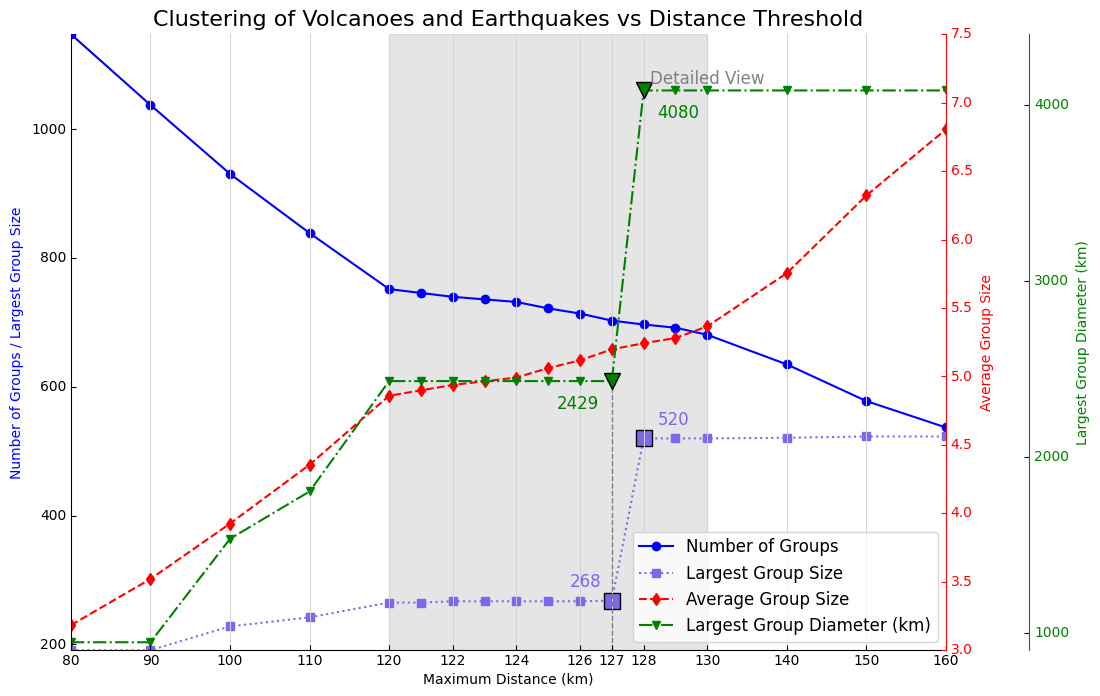

In [21]:
# --- Load volcano and earthquake coordinates ---

# Function to parse coordinate strings
# Helper to process "Point(lon lat)" format to (lat, lon)
def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

# Read volcanoes
with open("volcanoes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

# Read earthquakes
with open("earthquakes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

# --- Combine volcano and earthquake coordinates ---
all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

# --- Build KD-Tree for efficient neighbor search ---
tree = KDTree(np.radians(all_coords))  # Use radians for geodesic approximation

# --- Storage for metrics ---
groups_count_list = []
average_group_size_list = []
largest_group_size_list = []
largest_group_diameter_list = []


def haversine_distances(coords):
    """Approximate distances matrix on the sphere."""
    from sklearn.metrics.pairwise import haversine_distances
    return haversine_distances(np.radians(coords)) * 6371.0  # Radius of Earth

# --- Compute metrics for each distance ---
for dist_max in distances_max_list:
    G = nx.Graph()

    for idx, coord in enumerate(all_coords):
        G.add_node(idx, pos=coord, type=types[idx])

    # Find neighbors within dist_max for each point
    for idx, coord in enumerate(all_coords):
        indices = tree.query_ball_point(np.radians(coord), r=dist_max/6371.0)  # r must be in radians
        for neighbor_idx in indices:
            if neighbor_idx != idx:
                G.add_edge(idx, neighbor_idx)

    # Find connected components (groups)
    connected_components = list(nx.connected_components(G))
    groups_count_list.append(len(connected_components))    # число кластеров, где точки ближе друг к другу, чем dist_max

    # Compute group size metrics
    group_sizes = [len(group) for group in connected_components]
    average_group_size_list.append(np.mean(group_sizes) if group_sizes else 0)
    largest_group_size_list.append(np.max(group_sizes) if group_sizes else 0)

    # Compute diameter metrics
    group_diameters = []
    for group in connected_components:
        coords = [all_coords[idx] for idx in group]
        diameter = compute_group_diameter(coords)
        group_diameters.append(diameter)
    # group_diameters = [compute_group_diameter([all_coords[idx] for idx in group]) for group in connected_components]

    largest_group_diameter_list.append(np.max(group_diameters) if group_diameters else 0)

    print(f"dist_max={dist_max} km: {len(connected_components)} groups, average size {np.mean(group_sizes):.2f}, "
          f"largest group {np.max(group_sizes)}, largest diameter {np.max(group_diameters):.2f} km")

# --- Plot the results with three Y-axes ---

# Generate new "compressed" X axis for visual clarity in the 120–130 km range
# 📉 Compresses scale before 120, 📈 stretches 120-130, 📉 compresses after 130.
compress_before=0.5
compress_between=2.0
compress_after=0.5
new_x_list = [transform_x(x, compress_before, compress_between, compress_after) for x in distances_max_list]
real_to_new_x = dict(zip(distances_max_list, new_x_list))

plt.rcParams["axes.grid"] = False  # Disable default grid globally
fig = plt.figure(figsize=(14, 8))
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)
host.axis["top"].set_visible(False) # Отключаем верхнюю границу

par1 = host.twinx()  # Second Y-axis
par2 = host.twinx()  # Third Y-axis

# Offset the third Y-axis
offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2, offset=(offset, 0))
par2.axis["right"].toggle(all=True)

# Plot curves
p1, = host.plot(new_x_list, groups_count_list, marker='o', label="Number of Groups", color='blue')
p2, = host.plot(new_x_list, largest_group_size_list, marker='s', linestyle=':', label="Largest Group Size", color='mediumslateblue')
p3, = par1.plot(new_x_list, average_group_size_list, marker='d', linestyle='--', label="Average Group Size", color='red')
scaled_largest_diameter = [x/1000 for x in largest_group_diameter_list]
p4, = par2.plot(new_x_list, scaled_largest_diameter, marker='v', linestyle='-.', label="Largest Group Diameter (km)", color='green')

# Axis labels
host.set_xlim(min(new_x_list), max(new_x_list))
host.set_xlabel("Maximum Distance (km)", fontsize=14)
host.yaxis.set_label_position("left")
host.set_ylabel("Number of Groups / Largest Group Size", fontsize=14)
host.yaxis.label.set_color('blue')


# Activate second Y-axis (Average Group Size)
par1.axis["right"].toggle(all=True)  # Включаем ось
par1.set_ylabel("Average Group Size", fontsize=14)
par1.axis["right"].label.set_color("red")
par1.axis["right"].major_ticklabels.set_color("red")
par1.axis["right"].line.set_color("red")
par1.set_ylim(3, 7.5)
par1.tick_params(axis='y', colors='red')

# Third Y-axis (1000 - 4000 km)
par2.set_ylabel("Largest Group Diameter (km)", fontsize=14)
par2.axis["right"].label.set_color("green")
par2.axis["right"].major_ticklabels.set_color("green")
par2.axis["right"].line.set_color("green")
par2.set_ylim(0.9, 4.4)
par2.set_yticks([1, 2, 3, 4])
par2.set_yticklabels(["1000", "2000", "3000", "4000"], color='green')

# Turn off auto margins
host.margins(x=0, y=0)

# Highlight x=127 and x=128
highlight_xs = [127, 128]
highlight_idx = [distances_max_list.index(x) for x in highlight_xs]

# Draw larger markers for Largest Group Diameter and Largest Group Size
host.plot([real_to_new_x[127]], [largest_group_size_list[highlight_idx[0]]], marker='s', markersize=12, color='mediumslateblue', markeredgecolor='black')
host.plot([real_to_new_x[128]], [largest_group_size_list[highlight_idx[1]]], marker='s', markersize=12, color='mediumslateblue', markeredgecolor='black')
par2.plot([real_to_new_x[127]], [scaled_largest_diameter[highlight_idx[0]]], marker='v', markersize=12, color='green', markeredgecolor='black')
par2.plot([real_to_new_x[128]], [scaled_largest_diameter[highlight_idx[1]]], marker='v', markersize=12, color='green', markeredgecolor='black')

# Annotate points
host.annotate(f"{largest_group_size_list[highlight_idx[0]]:.0f}", xy=(real_to_new_x[127], largest_group_size_list[highlight_idx[0]]),
              xytext=(-30, 10), textcoords='offset points', fontsize=12, color='mediumslateblue')
host.annotate(f"{largest_group_size_list[highlight_idx[1]]:.0f}", xy=(real_to_new_x[128], largest_group_size_list[highlight_idx[1]]),
              xytext=(10, 10), textcoords='offset points', fontsize=12, color='mediumslateblue')
par2.annotate(f"{int(scaled_largest_diameter[highlight_idx[0]] * 1000)}", xy=(real_to_new_x[127], scaled_largest_diameter[highlight_idx[0]]),
              xytext=(-40, -20), textcoords='offset points', fontsize=12, color='green')
par2.annotate(f"{int(scaled_largest_diameter[highlight_idx[1]] * 1000)}", xy=(real_to_new_x[128], scaled_largest_diameter[highlight_idx[1]]),
              xytext=(10, -20), textcoords='offset points', fontsize=12, color='green')

# Highlight the range 120-130 km
host.axvspan(real_to_new_x[120], real_to_new_x[130], color='grey', alpha=0.2)
ymin, ymax = host.get_ylim()
host.text(real_to_new_x[120] + 20, ymax * 0.95 - 20, 'Detailed View', ha='center', fontsize=12, color='grey')



# дополнительную тонкую серую вертикальную линию на графике при x=127 (и при x=128)
# Get current ticks
current_xticks = host.get_xticks()

# Set ticks manually (including 127 if not already present)
selected_xticks = [80, 90, 100, 110, 120, 122, 124, 126, 127, 128, 130, 140, 150, 160]
host.set_xticks([real_to_new_x[val] for val in selected_xticks if val in real_to_new_x])
host.set_xticklabels([str(val) for val in selected_xticks if val in real_to_new_x], fontsize=10)

# Turn off grid and draw custom grid lines
host.grid(False)
for tick in selected_xticks:
    if tick in real_to_new_x:
        host.axvline(x=real_to_new_x[tick], color='lightgrey', linestyle='-', linewidth=0.7)


# Draw a short custom vertical line at x=127
if 127 in real_to_new_x:
    host.plot([real_to_new_x[127], real_to_new_x[127]], [191, 600],
              color='grey', linestyle='--', linewidth=1)




# Legend
lines = [p1, p2, p3, p4]
labels = [l.get_label() for l in lines]
host.legend(lines, labels, loc='lower right', fontsize=12)

# Hide top and right spines to remove horizontal frame lines
for spine in host.spines.values():
    spine.set_visible(False)

plt.title('Clustering of Volcanoes and Earthquakes vs Distance Threshold', fontsize=16)
# plt.grid(True)
plt.show()

In [22]:
# добавить текстовые подписи к точкам на всех кривых, но только для x=127 и x=128
# 📜 Полный код для аннотаций на графике
# --- Highlight selected points at x = 127 and 128 on green and brown curves ---

highlight_xs = [127, 128]

# Find indices of x = 127 and x = 128
highlight_indices = [distances_max_list.index(val) for val in highlight_xs]

# Values for brown curve (Largest Group Size)
highlight_brown_y = [largest_group_size_list[i] for i in highlight_indices]

# Draw larger triangle markers for green curve at selected points
#ax1.plot(
#    highlight_xs, highlight_green_y,
#    marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None', label='_nolegend_'
#)

# Draw larger square markers for brown curve at selected points
ax1.plot(
    highlight_xs, highlight_brown_y,
    marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None', label='_nolegend_'
)

# Annotate points

# Green curve annotations
#ax1.annotate(f"{highlight_green_y[0]:.1f}", xy=(highlight_xs[0], highlight_green_y[0]),
#             xytext=(-40, 15), textcoords='offset points', fontsize=12, color='green')
#ax1.annotate(f"{highlight_green_y[1]:.1f}", xy=(highlight_xs[1], highlight_green_y[1]),
#             xytext=(-5, 16), textcoords='offset points', fontsize=12, color='green')

# Brown curve annotations
ax1.annotate(f"{highlight_brown_y[0]:.0f}", xy=(highlight_xs[0], highlight_brown_y[0]),
             xytext=(-32, -22), textcoords='offset points', fontsize=12, color='brown')
ax1.annotate(f"{highlight_brown_y[1]:.0f}", xy=(highlight_xs[1], highlight_brown_y[1]),
             xytext=(20, -25), textcoords='offset points', fontsize=12, color='brown')





# Set exact X and Y limits
ax1.set_xlim(80, 160)
ax1.set_ylim(0, 1200)

NameError: name 'ax1' is not defined

In [ ]:
# Анализ объединения групп при dist_max=127 и dist_max=128
# Analyzing group merging at dist_max=127 and dist_max=128

import networkx as nx
import numpy as np
from scipy.spatial import KDTree

# Search parameters
dist_min = 127
dist_max = 128

# Using pre-defined volcano_coords and earthquake_coords
all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

# Building KD-tree for neighbor search
tree = KDTree(np.radians(all_coords))

# Function to build graph with given distance threshold
def build_graph(coords, dist_threshold_km):
    G = nx.Graph()
    for idx, coord in enumerate(coords):
        G.add_node(idx, pos=coord, type=types[idx])
        neighbors = tree.query_ball_point(np.radians(coord), r=dist_threshold_km/6371.0)
        for neighbor in neighbors:
            if neighbor != idx:
                G.add_edge(idx, neighbor)
    return G

# Build graphs for dist_max=127 and 128
G_127 = build_graph(all_coords, dist_min)
G_128 = build_graph(all_coords, dist_max)

# Get connected components (group lists)
groups_127 = list(nx.connected_components(G_127))
groups_128 = list(nx.connected_components(G_128))

print(f"Number of groups at {dist_min} km: {len(groups_127)}")
print(f"Number of groups at {dist_max} km: {len(groups_128)}")

# Create mapping: which group at 128km each point belongs to
node_to_group_128 = {}
for idx, group in enumerate(groups_128):
    for node in group:
        node_to_group_128[node] = idx

# Analyze groups at 127 km
# Check how many different 127km groups fall into the same 128km group

merged_groups = []

for group in groups_127:
    parent_groups = set(node_to_group_128[node] for node in group)
    if len(parent_groups) > 1:
        continue
    parent_group = next(iter(parent_groups))
    if len([g for g in groups_127 if any(node_to_group_128[n] == parent_group for n in g)]) > 1:
        merged_groups.append(group)

print(f"Number of merged groups: {len(merged_groups)}")

# Print group sizes
print("\nMerged Groups (sorted by size):")
merged_groups_sorted = sorted(merged_groups, key=lambda g: -len(g))
for i, g in enumerate(merged_groups_sorted):
    volcanoes = sum(1 for n in g if types[n] == 'volcano')
    earthquakes = sum(1 for n in g if types[n] == 'earthquake')
    print(f"Group {i+1}: Size = {len(g)} (Volcanoes: {volcanoes}, Earthquakes: {earthquakes})")

# Save found groups for future visualization
merged_groups_for_viz = merged_groups_sorted

# 📍 Computing the Center Based on the Farthest Pair

The function `compute_center_by_farthest_pair(group_coords)` finds the two most distant points in a group and calculates the geographic midpoint between them.

**Main idea:**
- Iterate through all point pairs to find the maximum geodesic distance.
- Take the midpoint between the two farthest points.
- Use this midpoint as a more accurate center for drawing coverage circles.

✨ This method ensures that at least the most distant points are well-centered inside the circle.

---

# 📍 Вычисление центра на основе самой удалённой пары точек

Функция `compute_center_by_farthest_pair(group_coords)` находит две наиболее удалённые точки в группе и вычисляет географический центр между ними.

**Основная идея:**
- Перебрать все пары точек и найти пару с максимальным геодезическим расстоянием.
- Вычислить середину между двумя самыми удалёнными точками.
- Использовать эту середину как более точный центр для построения круга охвата.

✨ Этот метод гарантирует, что хотя бы самые удалённые точки окажутся внутри построенного круга.

In [ ]:
def compute_center_by_farthest_pair(group_coords):
    max_distance = 0
    farthest_pair = (0, 0)
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
                farthest_pair = (i, j)
    # Midpoint between two farthest points
    lat1, lon1 = group_coords[farthest_pair[0]]
    lat2, lon2 = group_coords[farthest_pair[1]]
    center_lat = (lat1 + lat2) / 2
    center_lon = (lon1 + lon2) / 2
    return (center_lat, center_lon)


# Helper to compute center of a group (average coordinates)
def compute_center(coords):
    latitudes = [c[0] for c in coords]
    longitudes = [c[1] for c in coords]
    return np.mean(latitudes), np.mean(longitudes)

# 📜 Жадное покрытие группы кругами с максимальным охватом (Greedy Covering with Maximum Coverage) 🗺️

## 🇷🇺 Описание на русском:

Функция `draw_cover_circles_greedy` реализует улучшенный жадный алгоритм покрытия группы кругами:

**Основная идея:**
- На каждом шаге выбирается та вершина, которая покрывает наибольшее количество ещё непокрытых вершин.
- Строится окружность радиусом `dist_max` вокруг этой вершины.
- Все попавшие в окружность вершины удаляются из рассмотрения.
- Процесс повторяется, пока все вершины не будут покрыты.

✨ Это минимизирует общее число кругов и позволяет сохранить карту более чистой и понятной.

---

## 🇬🇧 Description in English:

The function `draw_cover_circles_greedy` implements an improved greedy algorithm for group covering with circles:

**Main idea:**
- At each step, select the node that covers the maximum number of uncovered points.
- Draw a circle with radius `dist_max` around the selected node.
- Remove all points inside the circle from the list.
- Repeat until all nodes are covered.

✨ This minimizes the total number of circles and keeps the map clean and readable.

In [ ]:
# Greedy covering: select the most effective center at each step
from geopy.distance import geodesic

def draw_cover_circles_greedy_effective(group_nodes, group_coords, color, dist_max_km, map_obj, dashed=False):
    remaining_nodes = set(range(len(group_nodes)))
    used_nodes = set()
    dist_threshold = dist_max_km  # maximum allowed distance (radius)

    while remaining_nodes:
        best_idx = None
        best_coverage = set()

        for idx in remaining_nodes:
            center_coord = group_coords[idx]
            covered = set()
            for j in remaining_nodes:
                if idx != j:
                    d = geodesic(center_coord, group_coords[j]).km
                    if d <= dist_threshold:
                        covered.add(j)
            # Always include the center itself
            covered.add(idx)

            if len(covered) > len(best_coverage):
                best_idx = idx
                best_coverage = covered

        # Draw the circle around the best node
        center_coord = group_coords[best_idx]
        folium.Circle(
            location=center_coord,
            radius=dist_max_km * 1000,  # meters
            color=color,
            fill=False,
            weight=2,
            opacity=0.7,
            dash_array="5,5" if dashed else None
        ).add_to(map_obj)

        # Remove covered nodes from the set
        remaining_nodes -= best_coverage
        used_nodes.add(best_idx)

# 🗺️ **Map of Merged Volcano and Earthquake Groups** 🌋⚡

This map shows two largest groups that merged when the distance threshold changed from 127 km to 128 km:
- 🔴 Red dots: Volcanoes
- ⚫ Black dots: Earthquakes

# 📜 Visualization of Volcano-Earthquake Groups with MST 🌋🌎

This cell visualizes the two largest merged groups using Minimum Spanning Trees (MST).  
Main features:
- Volcanoes and earthquakes are shown with different colors and shapes.
- MST edges are colored differently for Group 1 and Group 2.
- Solid lines for Group 1, dashed lines for Group 2 for better black-and-white printing.
- Thicker edges connect volcanoes and earthquakes.
- A coverage circle of 127 km radius is drawn around each group.
- Smaller and semi-transparent points are used to reduce clutter.

✨ An interactive legend explains the colors, symbols, and lines.

In [ ]:
import folium
import numpy as np
import networkx as nx
from geopy.distance import geodesic

# Select two largest groups
group1 = list(merged_groups_for_viz[0])
group2 = list(merged_groups_for_viz[1])

# Helper function to build MST for a group
def build_mst(group_nodes):
    coords = [all_coords[idx] for idx in group_nodes]
    G = nx.Graph()
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            dist = geodesic(coords[i], coords[j]).km
            G.add_edge(i, j, weight=dist)
    mst = nx.minimum_spanning_tree(G)
    return mst, coords

# Build MSTs
mst1, coords1 = build_mst(group1)
mst2, coords2 = build_mst(group2)

center1 = compute_center(coords1)
center2 = compute_center(coords2)

# Create the map
m = folium.Map(location=center1, zoom_start=3)

# Draw MST for Group 1
for edge in mst1.edges():
    idx1, idx2 = edge
    coord1 = coords1[idx1]
    coord2 = coords1[idx2]
    node1 = group1[idx1]
    node2 = group1[idx2]
    is_mixed = (types[node1] != types[node2])
    folium.PolyLine(
        locations=[coord1, coord2],
        color="purple",
        weight=4 if is_mixed else 2,
        opacity=1,
        dash_array=None
    ).add_to(m)

# Draw MST for Group 2
for edge in mst2.edges():
    idx1, idx2 = edge
    coord1 = coords2[idx1]
    coord2 = coords2[idx2]
    node1 = group2[idx1]
    node2 = group2[idx2]
    is_mixed = (types[node1] != types[node2])
    folium.PolyLine(
        locations=[coord1, coord2],
        color="green",
        weight=4 if is_mixed else 2,
        opacity=1,
        dash_array="5,5"
    ).add_to(m)

# Draw points for Group 1
degree_count1 = dict(mst1.degree())
for idx, coord in enumerate(coords1):
    node = group1[idx]
  # size = 4 if degree_count1[idx] == 1 else 7
    size = 1 if degree_count1[idx] == 1 else 3
    color = "red" if types[node] == "volcano" else "black"
    folium.CircleMarker(
        location=coord,
        radius=size,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(m)

# Draw points for Group 2
degree_count2 = dict(mst2.degree())
for idx, coord in enumerate(coords2):
    node = group2[idx]
#   size = 4 if degree_count2[idx] == 1 else 7
    size = 1 if degree_count1[idx] == 1 else 3
    color = "#FFA07A" if types[node] == "volcano" else "#2F4F4F"
    folium.RegularPolygonMarker(
        location=coord,
        number_of_sides=5 if types[node] == "volcano" else 4,
        radius=size,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(m)


# Compute diameters
diameter1 = compute_group_diameter(coords1)
diameter2 = compute_group_diameter(coords2)

print(f"Diameter of Group 1: {diameter1:.2f} km")
print(f"Diameter of Group 2: {diameter2:.2f} km")



# Compute better centers for Group 1 and Group 2
center1_better = compute_center_by_farthest_pair(coords1)
center2_better = compute_center_by_farthest_pair(coords2)

# Draw big circles with improved centers
folium.Circle(
    location=center1_better,
    radius=(diameter1 / 2) * 1000,  # meters
    color="purple",
    fill=False,
    weight=3,
    opacity=0.5
).add_to(m)

folium.Circle(
    location=center2_better,
    radius=(diameter2 / 2) * 1000,
    color="green",
    fill=False,
    dash_array="5,5",
    weight=3,
    opacity=0.5
).add_to(m)




# Greedy Covering with Circles - алгоритм "жадного покрытия группы кругами"
draw_cover_circles_greedy_effective(group1, coords1, color="purple", dist_max_km=127, map_obj=m, dashed=False)
draw_cover_circles_greedy_effective(group2, coords2, color="green", dist_max_km=127, map_obj=m, dashed=True)




# # Add legend
# legend_html = '''
# <div style="position: fixed;
#      bottom: 550px; left: 250px;
#      background-color: white;
#      border:2px solid grey; z-index:9999; font-size:14px;
#      padding-bottom: 3px; padding-right: 4px;">
#           &nbsp;<b>Legend</b><br>
#           &nbsp;<span style="color:red;">● Volcano (Group 1)</span><br>
#           &nbsp;<span style="color:black;">● Earthquake (Group 1)</span><br>
#           &nbsp;<span style="color:#FFA07A;">⬠ Volcano (Group 2)</span><br>
#           &nbsp;<span style="color:#2F4F4F;">■ Earthquake (Group 2)</span><br>
#           &nbsp;<span style="color:purple;">━ MST Edge (Group 1)</span><br>
#           &nbsp;<span style="color:green;">━ MST Edge Dashed (Group 2)</span>
# </div>
# '''

# Add legend with Russian text
legend_html = '''
<div style="position: fixed;
     bottom: 550px; left: 250px;
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     padding-bottom: 3px; padding-right: 4px;">
     &nbsp;<b>Легенда</b><br>
     &nbsp;<span style="color:purple;">━ Группа 1</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:red;">● Вулкан</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:black;">● Землетрясение</span><br>
     &nbsp;<span style="color:green;">━ Группа 2, пунктир</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:#FFA07A;">⬠ Вулкан</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:#2F4F4F;">■ Землетрясение</span><br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

пересчёт координат и построения графика


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Generate new "compressed" X axis ---

new_x_list = []
current_x = 0

for x_val in distances_max_list:
    if 80 <= x_val < 120:
        delta = (x_val - 80) * 0.5  # compress
        new_x = delta
    elif 120 <= x_val <= 130:
        delta = (x_val - 120) * 2 + (120 - 80) * 0.5  # expand
        new_x = delta
    else:  # 130 < x_val <= 170
        delta = (x_val - 130) * 0.5 + (130 - 80) * 0.5 + (130 - 120) * 2
        new_x = delta
    new_x_list.append(new_x)

# Save mapping for real x-values
real_to_new_x = dict(zip(distances_max_list, new_x_list))
new_to_real_x = dict(zip(new_x_list, distances_max_list))

# --- Plot using new X axis ---

fig, ax = plt.subplots(figsize=(16,8))

# Plot curves
ax.plot(new_x_list, groups_count_list, marker='o', label="Number of Groups", color='blue')
ax.plot(new_x_list, largest_group_size_list, marker='s', label="Largest Group Size", color='orange')

# Plot Average Group Size (scaled manually)
scaled_average_group_size = np.array(average_group_size_list) * 30 - 90
ax.plot(new_x_list, scaled_average_group_size, marker='d', linestyle='--', label="Average Group Size (scaled)", color='red')

# Vertical grey lines at x=127
ax.axvline(real_to_new_x[127], color='grey', linestyle='--', linewidth=1)

# Highlight 127, 128 points
highlight_xs = [127, 128]
highlight_indices = [distances_max_list.index(val) for val in highlight_xs]

highlight_yellow_y = [largest_group_size_list[i] for i in highlight_indices]

# Draw enlarged markers
#ax.plot([real_to_new_x[127]], [highlight_green_y[0]], marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None')
#ax.plot([real_to_new_x[128]], [highlight_green_y[1]], marker='^', markersize=14, markeredgecolor='black', markerfacecolor='green', linestyle='None')

ax.plot([real_to_new_x[127]], [highlight_yellow_y[0]], marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None')
ax.plot([real_to_new_x[128]], [highlight_yellow_y[1]], marker='s', markersize=14, markeredgecolor='black', markerfacecolor='orange', linestyle='None')

# Annotate points
#ax.annotate(f"{highlight_green_y[0]:.1f}", (real_to_new_x[127], highlight_green_y[0]),
#            textcoords="offset points", xytext=(-40, 15), fontsize=12, color='green')
#ax.annotate(f"{highlight_green_y[1]:.1f}", (real_to_new_x[128], highlight_green_y[1]),
#            textcoords="offset points", xytext=(-5, 16), fontsize=12, color='green')

ax.annotate(f"{highlight_yellow_y[0]:.0f}", (real_to_new_x[127], highlight_yellow_y[0]),
            textcoords="offset points", xytext=(-32, -22), fontsize=12, color='orange')
ax.annotate(f"{highlight_yellow_y[1]:.0f}", (real_to_new_x[128], highlight_yellow_y[1]),
            textcoords="offset points", xytext=(20, -25), fontsize=12, color='orange')

# Set X-ticks: real distances, but placed according to compressed x
selected_xticks = [80, 90, 100, 110, 120, 122, 124, 126, 127, 128, 130, 140, 150, 160]
ax.set_xticks([real_to_new_x[val] for val in selected_xticks])
ax.set_xticklabels(selected_xticks, fontsize=10)

# Labels and grid
ax.set_xlabel('Maximum Distance (km)', fontsize=14)
ax.set_ylabel('Metrics', fontsize=14)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True)

plt.title('Clustering of Volcanoes and Earthquakes with Zoomed 120–130 km Range', fontsize=16)
plt.show()

📜 поиск локального изгиба через вторую производную

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume distances_max_list and groups_count_list are already calculated

# Convert lists to numpy arrays for easier processing
x = np.array(distances_max_list)
y = np.array(groups_count_list)

# Compute first derivative (differences)
dy_dx = np.gradient(y, x)

# Compute second derivative
d2y_dx2 = np.gradient(dy_dx, x)

# Find index of maximum absolute second derivative (largest curvature)
elbow_idx = np.argmax(np.abs(d2y_dx2))
elbow_dist = x[elbow_idx]

print(f"Elbow point detected at dist_max ≈ {elbow_dist} km using second derivative method.")

# --- Optionally, plot second derivative curve to visualize

plt.figure(figsize=(12,6))
plt.plot(x, d2y_dx2, marker='o')
plt.axvline(x=elbow_dist, color='red', linestyle='--', label=f"Elbow at {elbow_dist} km")
plt.title("Second Derivative of Group Count Curve")
plt.xlabel("Maximum Distance (km)")
plt.ylabel("Second Derivative (curvature)")
plt.grid(True)
plt.legend()
plt.show()